# **Trend fitting in extreme precipitation during OND in the Horn of Africa**

In [16]:
source("../wwa_model-fitting.R")

In [2]:
cov_lag <- "SON"

ts <- merge(load_ts("ts/HoA-flooding_mswep_OND_rx3day.dat", col.names = c("year", "rx3day")),
            load_ts("ts/HoA-flooding_mswep_OND_30day_mean.dat", col.names = c("year", "rx30day")))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

gmst <- load_ts("ts/gmst.dat", col.names = c("year", "gmst"))
iod <- load_ts(paste0("ts/iod_", toupper(cov_lag), ".dat"), col.names = c("year", "iod"))
nino <- load_ts(paste0("ts/nino3.4-detrended_", toupper(cov_lag), ".dat"), col.names = c("year", "nino34"))

df <- merge(merge(merge(gmst, iod), nino), ts)

df$log_rx3day <- log(df$rx3day)
df$log_rx30day <- log(df$rx30day)

In [330]:
panel.cor <- function(x, y, digits=2, prefix="", cex.cor, ...)
{
    usr <- par("usr")
    par(usr = c(0, 1, 0, 1))
    r <- abs(cor(x, y))
    txt <- format(c(r, 0.123456789), digits=digits)[1]
    txt <- paste(prefix, txt, sep="")
    
    text(0.5, 0.5, txt, cex = 1.2)
    par("usr" = usr)
}
 

## **Modified code for multiple linear regression**


In [17]:
ns_loglik <- function(pars, cov, x, dist, fittype) {

    effect <- rowSums(pars[grepl("alpha", names(pars))] * cov)
    
    # compute nonstationary location & scale
    if(fittype == "fixeddisp") {
        const = exp(effect / pars["mu0"])
        loc = pars["mu0"] * const
        scale = pars["sigma0"] * const
    } else if(fittype == "shift") {
        loc = pars["mu0"] + effect
        scale = pars["sigma0"]
    } else {
        print(paste(fittype, "not implemented"))
        return()
    }

    # constrain variance to be strictly positive
    if(any(scale <= 0)) return(NA)
        
    # return negative log-likelihood
    if(dist == "norm") {
        return(-sum(dnorm(x, mean = loc, sd = scale, log = T)))
    } else if(dist == "gev") {
        shape = pars["shape"]
        return(-sum(devd(x, loc = loc, scale = scale, shape = shape, log = T)))
    } else {
        print(paste(dist, "not implemented"))
        return()
    }
}

In [18]:
fit_ns <- function(dist, type = "fixeddisp", data, varnm, covnm, lower = F, mintemps = F, ev = NA, method = "BFGS", ...) {
    
    # currently only works for distributions fully specified by mean & sd: only tested for normal, lognormal
    if(! dist %in% c("norm", "gev")) {
        print("Not yet implemented: use norm or gev")
        return()
    }
    
    # add something here to automatically handle no covariates
    
    # if looking at minimum temperatures (or minima of negative values generally), need to flip data for stable model fitting
    x <- data[,varnm]; if(mintemps) x <- -x
    cov <- data[, covnm, drop = F]
    k <- length(covnm)
    
    # fit model with appropriate number of parameters, pad if necessary
    init <- c("mu0" = mean(x), "sigma0" = sd(x), setNames(rep(0,k), paste0("alpha_", covnm)))

    if(dist == "gev") init <- c(init, "shape" = 0)
    fitted <- suppressWarnings(optim(par = init, ns_loglik, cov = cov, x = x, dist = dist, fittype = type, method = method))
    
    # if looking at minimum temperatures (or minima of negative values generally), so trend & location parameters have been flipped. This may cause some confusion so may have to modify later!
    if(mintemps) {
        fitted[["NOTE"]] <- "NB: model parameters are estimated for negative values"
        fitted$par["mu0"] <- -fitted$par["mu0"]
        fitted$par[grepl("alpha", names(fitted$par))] <- -fitted$par[grepl("alpha", names(fitted$par))]
        x <- -x
    }
            
    # attach assorted useful information
    fitted[["dist"]] <- dist
    fitted[["type"]] <- type
    fitted[["varnm"]] <- varnm
    fitted[["covnm"]] <- covnm
    fitted[["data"]] <- data
    fitted[["x"]] <- x
    fitted[["cov"]] <- cov
    
    fitted[["lower"]] <- lower               # saves having to specify every time later on
    fitted[["mintemps"]] <- mintemps         # look at maxima of 0-temps, rather than minima of observed temps
    
    if(is.na(ev)) { ev <- x[length(x)] } # event value: assume that event of interest is most recent, unless told otherwise (used in later plotting functions)
    fitted[["ev"]] <- ev

    return(fitted)
}

In [19]:
refit <- function(mdl, new_df) {
    fit_ns(dist = mdl$dist, type = mdl$type, data = new_df, varnm = mdl$varnm, covnm = mdl$covnm, lower = mdl$lower, mintemps = mdl$mintemps, ev = mdl$ev)
}

In [20]:
ns_pars <- function(mdl, fixed_cov = NA) {
    
    # if no covariate value given, evaluate at all covariate values
    if(is.na(unlist(fixed_cov)[1])) fixed_cov <- mdl$cov
    
    # calculate the nonstationary parameter values
    pars <- mdl$par
    
    effect <- rowSums(pars[grepl("alpha", names(pars)), drop = F] * fixed_cov)
    
    if(mdl$type == "fixeddisp") {
        
        ns_const = exp(effect / pars["mu0"])
        loc = pars["mu0"] * ns_const
        scale = pars["sigma0"] * ns_const
        
    } else if(mdl$type == "shift") {
        loc = pars["mu0"] + effect
        scale = rep(pars["sigma0"], length(loc))
    } else {
        print(paste(mdl$type,"not implemented"))
        return()
    }
        
    # return the list of named parameters: location, scale, shape (if applicable)
    if("shape" %in% names(pars)) {
        return(lapply(list("loc" = loc, "scale" = scale, "shape" = rep(pars["shape"], length(scale))), unname))
    } else {
        return(lapply(list("loc" = loc, "scale" = scale), unname))
    }
}

In [21]:
mdl_ests <- function(mdl, cov, cov_cf, ev, rp = NA) {

    pars <- mdl$par
    disp <- unname(pars["sigma0"] / pars["mu0"])

    if(is.na(rp)) rp <- return_period(mdl, ev, fixed_cov = cov)

    if(is.finite(rp)) {
        c(pars,
          "disp" = disp, 
          "event_magnitude" = ev, 
          "return_period" = rp, 
          "PR" = prob_ratio(mdl, ev, cov, cov_cf),
          "dI_abs" = int_change(mdl, rp, cov, cov_cf, relative = F),
          "dI_rel" = int_change(mdl, rp, cov, cov_cf, relative = T))
    } else {
        return(rep(NA, 10))
    }
}

In [22]:
plot_returnlevels <- function(mdl, cov, cov_cf, ev, ylim = NA, pch = 20, ylab = NA, legend_pos = "topright", main = "", 
                              xlim = c(1,10000), legend_labels = c("Present climate", "Counterfactual climate"), seed = 42, nsamp = 500, ...) {
    
    x <- mdl$x
    if(missing(ev)) { ev <- mdl$ev }
    
    rp_x <- unique(c(seq(1.1,2,0.1), seq(2,100,1), seq(100,1000,10), seq(100,1000,100), seq(1000,10000,1000)))     # return periods at which to calculate values for curves
    rp_th <- 1/seq(1,0,length.out = length(x)+2)[2:(length(x)+1)]                                                  # quantiles to map against observations to check fit

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # calculate return periods & return levels
    
    rl_curve_pres <- map_from_u(1/rp_x, mdl, fixed_cov = cov)
    rl_curve_cf <- map_from_u(1/rp_x, mdl, fixed_cov = cov_cf)

    rl_obs_pres <- map_from_u(map_to_u(mdl), mdl, fixed_cov = cov)
    rl_obs_cf <- map_from_u(map_to_u(mdl), mdl, fixed_cov = cov_cf)

    rp_event_pres <- 1/map_to_u(mdl, ev, fixed_cov = cov)
    rp_event_cf <- 1/map_to_u(mdl, ev, fixed_cov = cov_cf)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # prep axes
    
    if(is.na(ylim[1])) { ylim <- range(pretty(c(x, rl_curve_pres, rl_curve_cf))) }
    if(is.na(ylab)) {ylab <- mdl$varnm}
    # if((substr(mdl$varnm,1,3) == "log") & (ylim[1] <= 0)) { ylim[1] <- 0.01 }
    
    # plot
    plot(0,type = "n", xlim = xlim, ylim = ylim, log = "x", xlab = "", ylab = "", main = main)
    mtext("Return period (years)", side = 1, line = 2.5, cex = par("cex"))
    mtext(ylab, side = 2, line = 2.5, cex = par("cex"))
    
    legend(legend_pos, legend = c(legend_labels, "Observed event"), col = c("firebrick", "blue", "magenta"), lty = 1, pch = c(pch,pch,NA), bty = "n")

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # return period curves
    lines(rp_x, rl_curve_pres, lwd = 2, col = "firebrick", lty = 1)       # present climate
    lines(rp_x, rl_curve_cf, lwd = 2, col = "blue", lty = 1)              # counterfactual
    
    # expected return periods vs return levels transformed to stationarity at that covariate value
    points(rp_th, sort(rl_obs_pres, decreasing = mdl$lower), col = "firebrick", pch = pch)      # present
    points(rp_th, sort(rl_obs_cf, decreasing = mdl$lower), col = "blue", pch = pch)             # counterfactual
    
    # horizontal line showing observed event, plus ticks showing return periods
    abline(h = ev, col = "magenta", lty = 2)
    suppressWarnings(rug(rp_event_pres, lwd = 3, col = "firebrick"))   # present
    suppressWarnings(rug(rp_event_cf, lwd = 3, col = "blue"))          # counterfactual
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Add confidence intervals to return periods
    
    if(!is.na(nsamp)) {
        x_ci <- c(5,10,20,50,100,200,500,1000,2000,5000,10000)
        set.seed(seed)

        mdl_df <- mdl_fd$data[,c(mdl$varnm, mdl$covnm)]
        boot_res <- sapply(1:nsamp, function(i) {
            boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
            tryCatch({
                boot_mdl <- refit(mdl, boot_df)
                c(map_from_u(1/x_ci, boot_mdl, fixed_cov = cov), map_from_u(1/x_ci, boot_mdl, fixed_cov = cov_cf))
            }, error = function(cond) {return(rep(NA, length(x_ci)*2))})
        })
        est_ci <- apply(boot_res, 1, quantile, c(0.025, 0.975), na.rm = T)
        
        # lines bounding confidence intervals
        # matplot(x_ci, t(est_ci[,1:length(x_ci)]), type = "l", lty = 1, lwd = 2, col = adjustcolor("firebrick", alpha = 0.3), add = T)
        # matplot(x_ci, t(est_ci[,-(1:length(x_ci))]), type = "l", lty = 1, lwd = 2, col = adjustcolor("blue", alpha = 0.3), add = T)
        
        # shaded region for confidence intervals
        polygon(x = c(x_ci, rev(x_ci)), y = c(est_ci[1,1:length(x_ci)], rev(est_ci[2,1:length(x_ci)])), density = NULL, border = NA, col = adjustcolor("firebrick", alpha = 0.1))
        polygon(x = c(x_ci, rev(x_ci)), y = c(est_ci[1,-(1:length(x_ci))], rev(est_ci[2,-(1:length(x_ci))])), density = NULL, border = NA, col = adjustcolor("blue", alpha = 0.1))
    }
}

In [23]:
plot_trend <- function(mdl, ev, ev_year, ylab = NA, legend_pos = "topleft", main = "", ylim = NA, ...) {
    
    if(is.na(ylab)) {ylab <- mdl$varnm}
    if(is.na(ylim[1])) { ylim <- range(pretty(mdl$x)) }
    if(missing(ev)) { ev <- mdl$ev }
    if(missing(ev_year)) { ev_year <- mdl$data$year[which.min(abs(mdl$x - ev))] }
    
    plot(mdl$data$year, mdl$x, type = "S", lwd = 2, col = adjustcolor("black", alpha = 1), xlab = "Year", ylab = ylab, main = main, ylim = ylim, ...)
    
    lines(mdl$data$year-0.5, ns_pars(mdl)$loc, col = adjustcolor("black", alpha = 0.5), lwd = 2)
    matplot(mdl$data$year-0.5, eff_return_level(c(6,40), mdl), type = "l", lty = 1, add = T, col = adjustcolor("blue", alpha = 0.5), lwd = c(2,1))
    
    points(ev_year-0.5, ev, col = "magenta", lwd = 2, pch = 0)
    
    # add legend
    legend(legend_pos, legend = c("location", "1-in-6-year event", "1-in-40-year event"), lty = 1, col = c("black", "blue", "blue"), lwd = c(2,2,1))
}

In [24]:
plot_covtrend <- function(mdl, xcov, cov, cov_cf, fixed_cov = NA, ev, ylim = NA, xlab = NA, ylab = NA, 
                          legend_pos = "topleft", main = "", seed = 42, nsamp = 1000) {

    if(is.na(xlab)) { xlab <- toupper(xcov)}
    if(is.na(ylab)) { ylab <- mdl$varnm}
    if(is.na(ylim[1])) { ylim <- range(pretty(mdl$x)) }
    if(missing(ev)) ev <- mdl$ev
    
    x <- mdl$cov[,xcov]
    o <- order(x)
    
    plot(x, mdl$x, pch = 20, main = main, xlab = "", ylab = "", ylim = ylim, xlim = range(c(x, cov[xcov], cov_cf[xcov])))
    mtext(xlab, side = 1, line = 2.5, cex = par("cex"))
    mtext(ylab, side = 2, line = 2.5, cex = par("cex"))
    
    points(cov[,xcov], ev, col = "magenta", lwd = 2, pch = 0)
    
    # trend lines
    lines(x[o], ns_pars(mdl, fixed_cov = fixed_cov)$loc[o], lwd = 3, col = "black", lty = 1)
    lines(x[o], eff_return_level(6, mdl, fixed_cov = fixed_cov)[o], col = "blue", lwd = 2, lty = 1)
    lines(x[o], eff_return_level(40, mdl, fixed_cov = fixed_cov)[o], col = "blue", lwd = 1, lty = 1)
    
#     # get confidence interval for mu'
#     if(~is.na(nsamp)) {
#         mdl_df <- mdl$data
#         set.seed(seed)
#         mu_ci <- apply(sapply(1:nsamp, function(i) {
#             boot_df <- mdl_df[sample(1:nrow(mdl_df), nrow(mdl_df), replace = T),]
#             tryCatch({
#                 boot_mdl <- refit(mdl, boot_df)
#                 c("mu_ev" = ns_pars(boot_mdl, fixed_cov = cov)$loc,
#                   "mu_cf" = ns_pars(boot_mdl, fixed_cov = cov_cf)$loc)
#             }, error = function(cond) {return(rep(NA, 2))})
#         }), 1, quantile, c(0.025, 0.975), na.rm = T)

#         # confidence interval & markers for mu' at factual & counterfactual covariates
#         lines(rep(cov[,xcov], 3), c(ns_pars(mdl, fixed_cov = cov)$loc, mu_ci[,"mu_ev"]), col = "black", lwd = 2, type = "o", pch = "_")
#         lines(rep(cov_cf[,xcov], 3), c(ns_pars(mdl, fixed_cov = cov_cf)$loc, mu_ci[,"mu_cf"]), col = "black", lwd = 2, type = "o", pch = "_")
#     }

    # add legend
    legend(legend_pos, legend = c("location", "1-in-6-year event", "1-in-40-year event"), lty = 1, col = c("black", "blue", "blue"), lwd = c(2,2,1))
}

---
# **Exploratory**

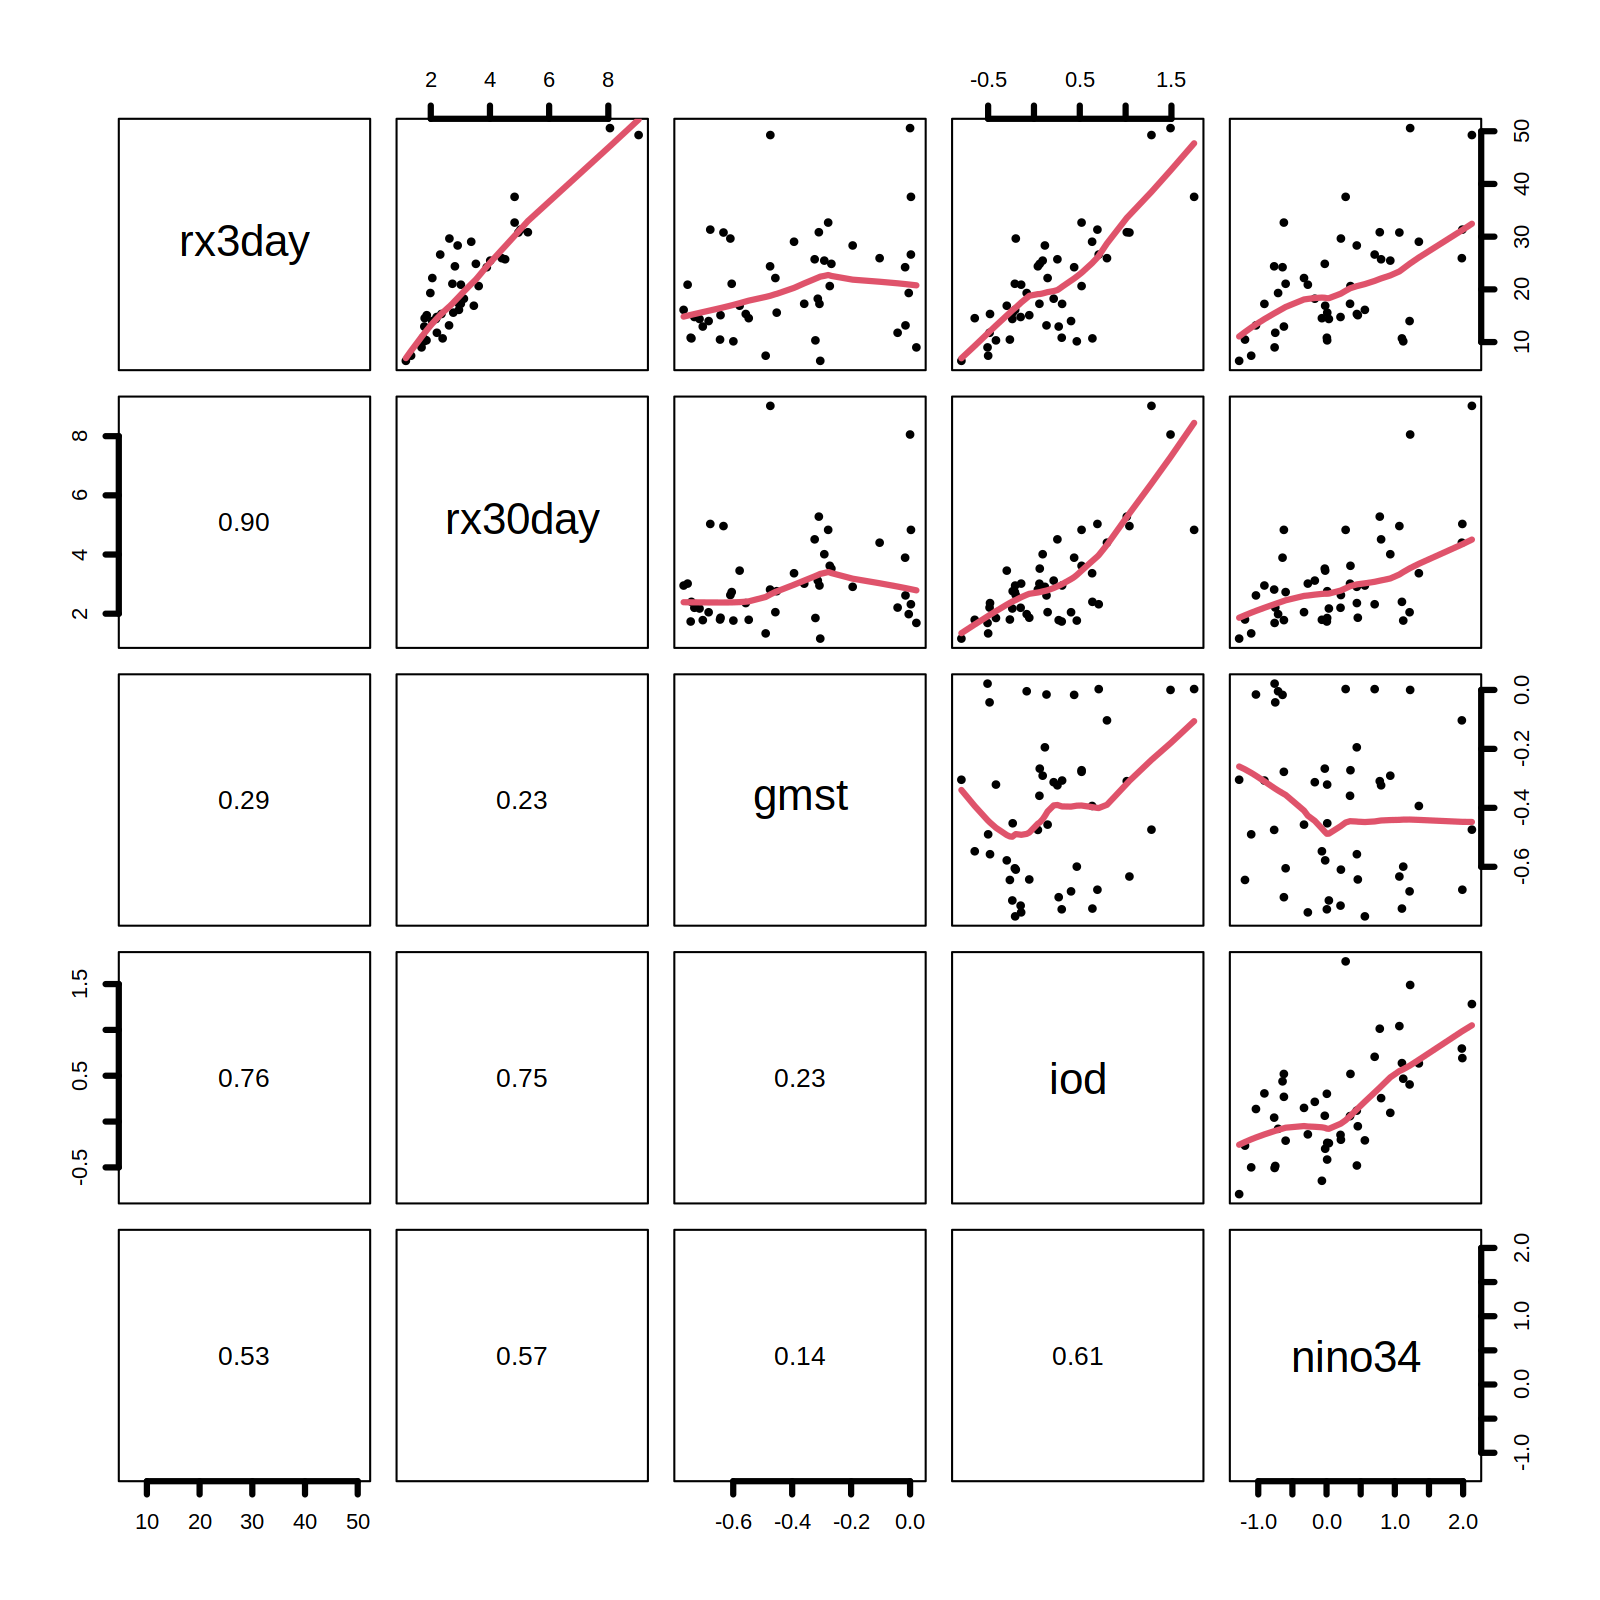

In [17]:
# relationship between all variables
pairs(df[,c("rx3day", "rx30day", "gmst", "iod", "nino34")], upper.panel=panel.smooth, lower.panel=panel.cor, lwd = 3, pch = 20)

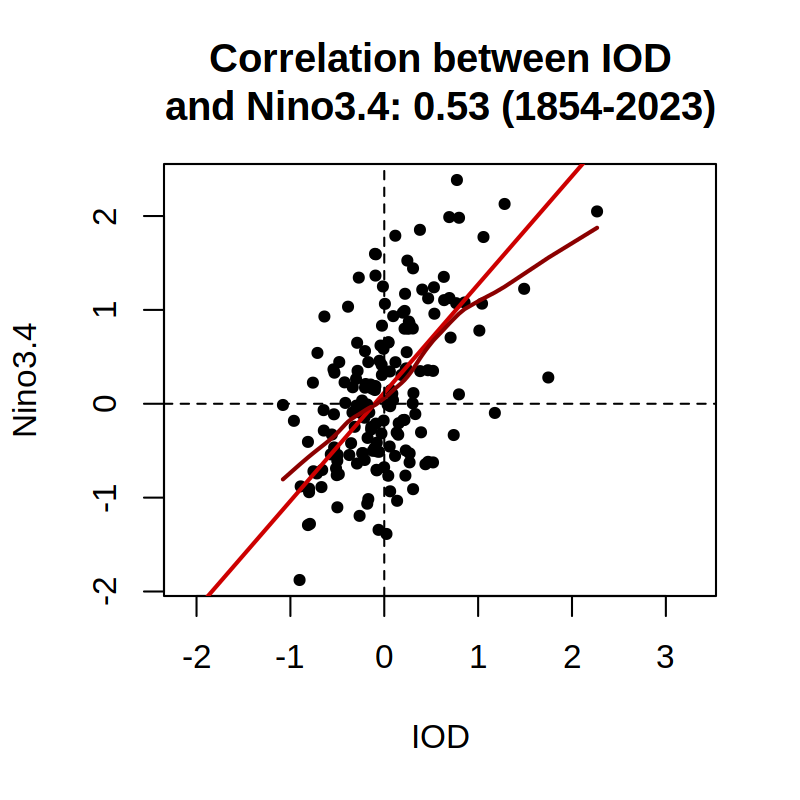

In [83]:
# relationship between IOD & ENSO
prep_window(c(1,1))
plot(iod$iod, nino$nino, asp = 1, xlab = "IOD", ylab = "Nino3.4", main = paste0("Correlation between IOD\nand Nino3.4: ",round(cor(iod$iod, nino$nino), 2), " (1854-2023)"))
abline(line(iod$iod, nino$nino), col = "red3", lwd = 2)
lines(lowess(iod$iod, nino$nino), col = "darkred", lwd = 2)
abline(h = 0, v = 0, lty = 2)

In [68]:
prep_window(c(1,2)); par(mfrow = c(1,1))
plot(iod, type = "S", lwd = 2, ylim = c(-3,3))
lines(nino$year, filter(nino$nino, rep(1/11,11), sides = 2), col = "blue")
abline(h = 0)

## **Lagged cross-correlations**

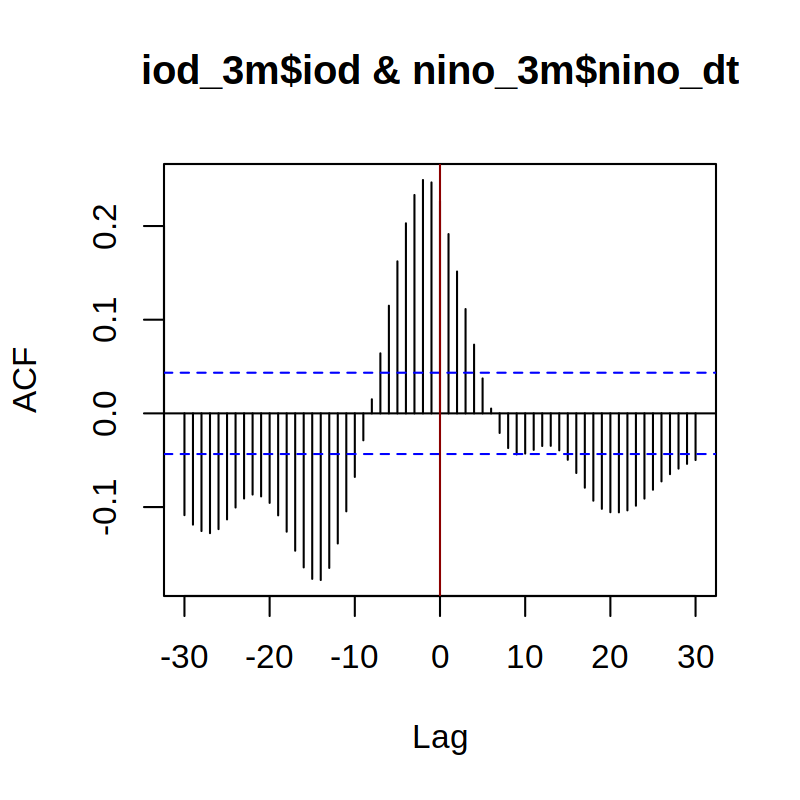

In [126]:
nino_3m <- read.csv("data/nino3.4rel_3month.csv")
iod_3m <- read.csv("data/iod_3month.csv")
ccf(iod_3m$iod, nino_3m$nino_dt)
abline(v = 0, col = "darkred")

In [127]:
cor(iod_3m$iod, nino_3m$nino_dt)
cor(iod_3m$iod[1:2039], nino_3m$nino_dt[2:2040])
cor(iod_3m$iod[1:2038], nino_3m$nino_dt[3:2040]) # 2-month lag between IOD and Nino?
cor(iod_3m$iod[1:2037], nino_3m$nino_dt[4:2040])

[1] 0.2266493

[1] 0.2476475

[1] 0.2511912

[1] 0.2357356

In [175]:
nino_3m$year <- as.integer(substr(nino_3m$time,1,4))
iod_3m$year <- as.integer(substr(iod_3m$time,1,4))

iod_6m <- load_ts("ts/iod_JASOND.dat", col.names = c("year", "iod_jasond"))

[1] 0.6915629

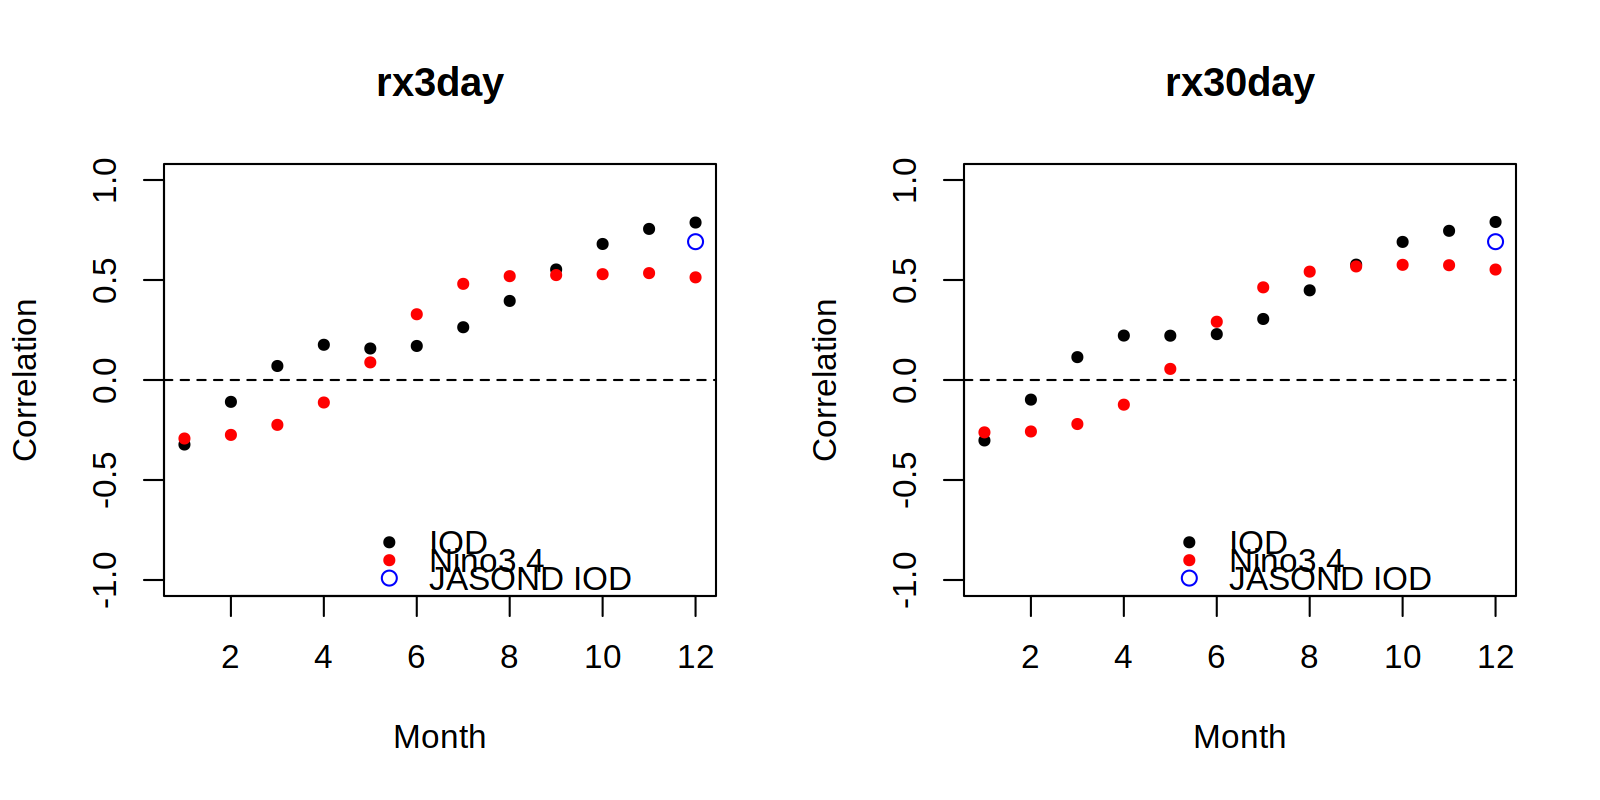

In [186]:
# check correlations between IOD/Nino3.4 and OND RX3day & RX30day at each lag
prep_window(c(1,2))

invisible(sapply(c("rx3day", "rx30day"), function(vnm) {
    plot(0, type = "n", xlim = c(1,12), ylim = c(-1,1), xlab = "Month", ylab = "Correlation", main = vnm)
    
    invisible(sapply(1:12, function(m) {
        df2 <- merge(merge(df[,c("year", vnm)], iod_3m[as.integer(substr(iod_3m$time,6,7)) == m, ]),
                     nino_3m[as.integer(substr(nino_3m$time,6,7)) == m, ])
        points(m, cor(df2$iod, df2[vnm]), pch = 20)
        points(m, cor(df2$nino_dt, df2[vnm]), pch = 20, col = "red")
    }))
    points(12, cor(merge(iod_6m, df)[,c("iod_jasond", "rx3day")])[1,2], col = "blue", pch = 1)
    abline(h = 0, lty = 2)
    legend("bottomright", c("IOD", "Nino3.4", "JASOND IOD"), pch = c(20,20,1), col = c("black", "red","blue"), bty = "n")
}))

# highest correlation is with OND IOD (although SON is not far off)

---
# **Model selection - linear model**

## **RX3day**

In [165]:
# log-rx3day is normal-ish - use this for quick linear model comparison
ks.test(scale(df$log_rx3day), pnorm)


	Exact one-sample Kolmogorov-Smirnov test

data:  scale(df$log_rx3day)
D = 0.087404, p-value = 0.8522
alternative hypothesis: two-sided


In [9]:
lm_3day <- lm(log_rx3day ~ gmst + nino34 + iod, df)
summary(lm_3day)


Call:
lm(formula = log_rx3day ~ gmst + nino34 + iod, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7905 -0.1523  0.0411  0.1958  0.6955 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.93849    0.10791  27.230  < 2e-16 ***
gmst         0.29543    0.21978   1.344 0.186262    
nino34       0.11923    0.07816   1.525 0.134849    
iod          0.45248    0.12305   3.677 0.000678 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3345 on 41 degrees of freedom
Multiple R-squared:  0.5364,	Adjusted R-squared:  0.5025 
F-statistic: 15.81 on 3 and 41 DF,  p-value: 5.568e-07


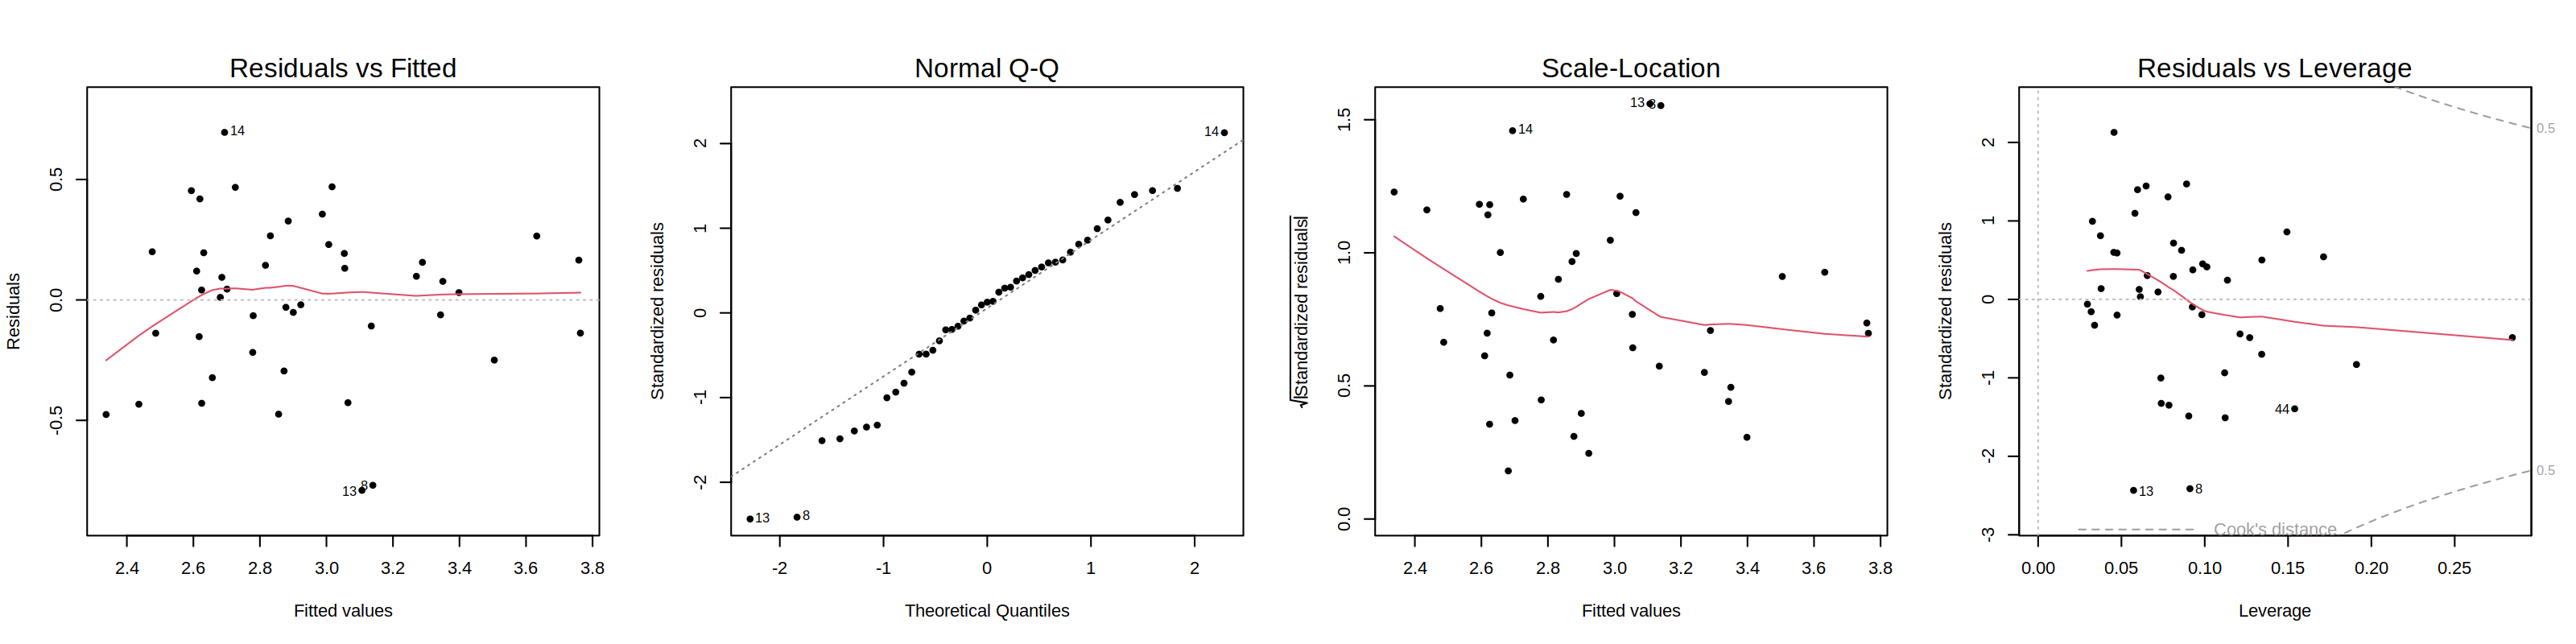

In [32]:
prep_window(c(1,4))

invisible(sapply(c(1,2,3,5), function(i) plot(lm_3day, which = i)))

## **RX30day**

In [10]:
# log-rx3day is normal-ish - use this for quick linear model comparison
ks.test(scale(df$log_rx30day), pnorm)


	Exact one-sample Kolmogorov-Smirnov test

data:  scale(df$log_rx30day)
D = 0.085413, p-value = 0.8702
alternative hypothesis: two-sided


In [11]:
lm_30day <- lm(log_rx30day ~ gmst + nino34 + iod, df)
summary(lm_30day)


Call:
lm(formula = log_rx30day ~ gmst + nino34 + iod, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.66491 -0.22292  0.04755  0.20199  0.47936 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.04013    0.09439  11.019 7.88e-14 ***
gmst         0.25936    0.19224   1.349 0.184683    
nino34       0.13314    0.06837   1.947 0.058357 .  
iod          0.42819    0.10763   3.978 0.000276 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2926 on 41 degrees of freedom
Multiple R-squared:  0.5917,	Adjusted R-squared:  0.5618 
F-statistic:  19.8 on 3 and 41 DF,  p-value: 4.316e-08


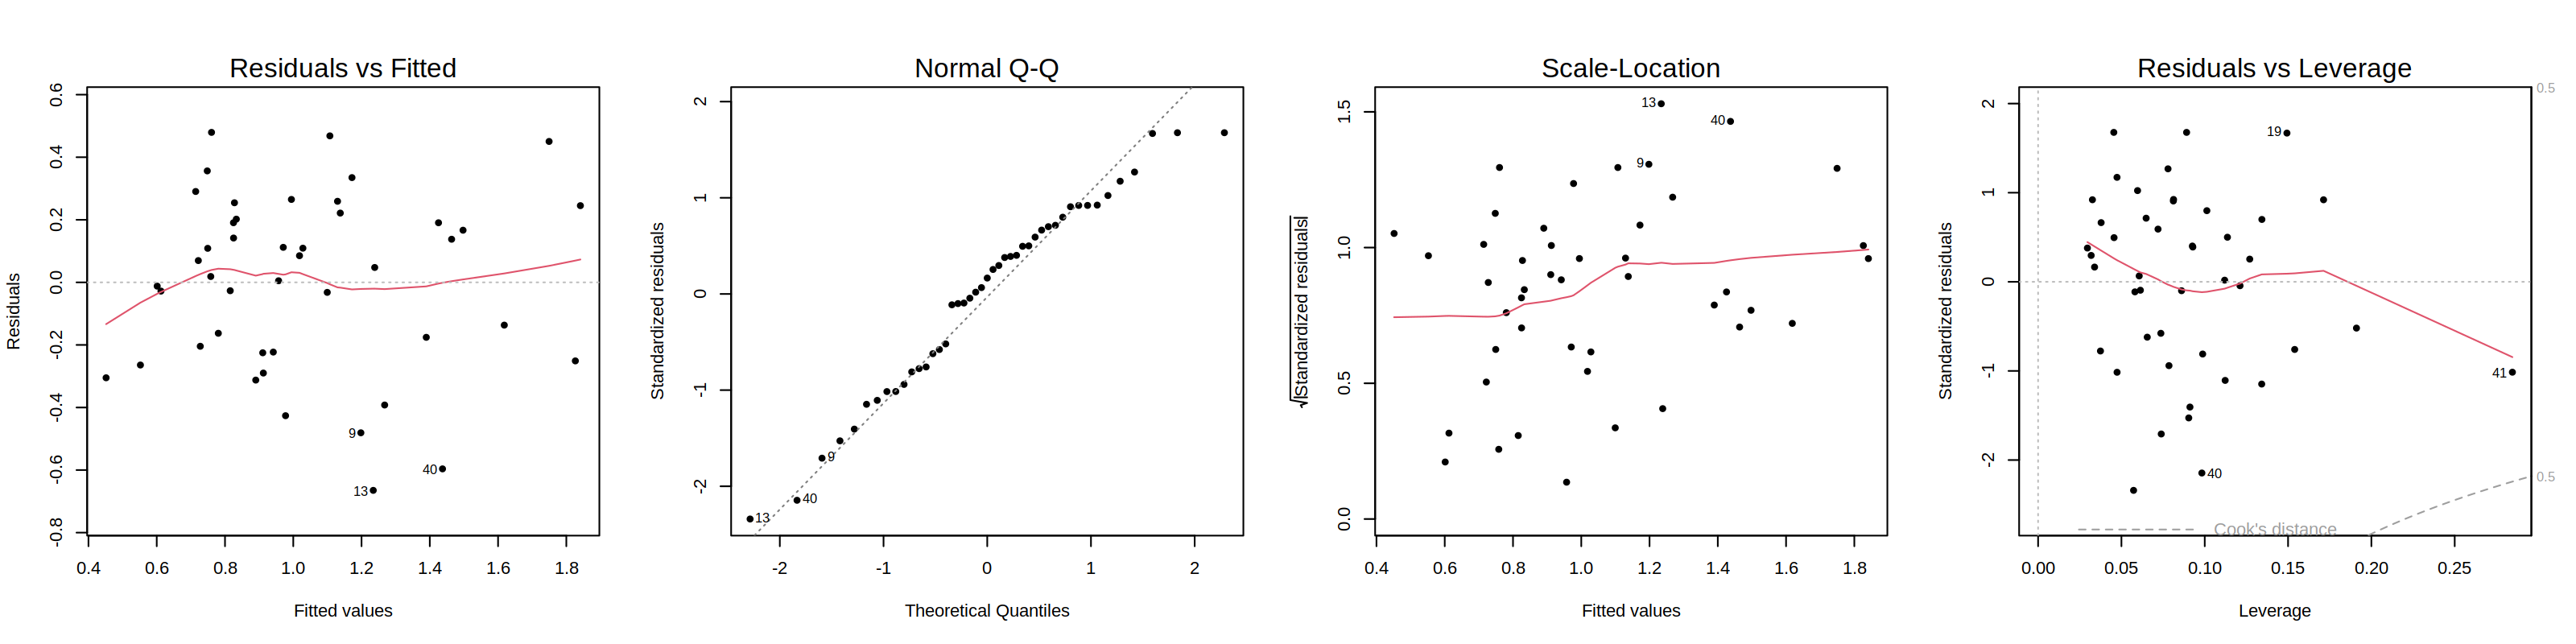

In [33]:
prep_window(c(1,4))
invisible(sapply(c(1,2,3,5), function(i) plot(lm_30day, which = i)))

## **Predicted values**

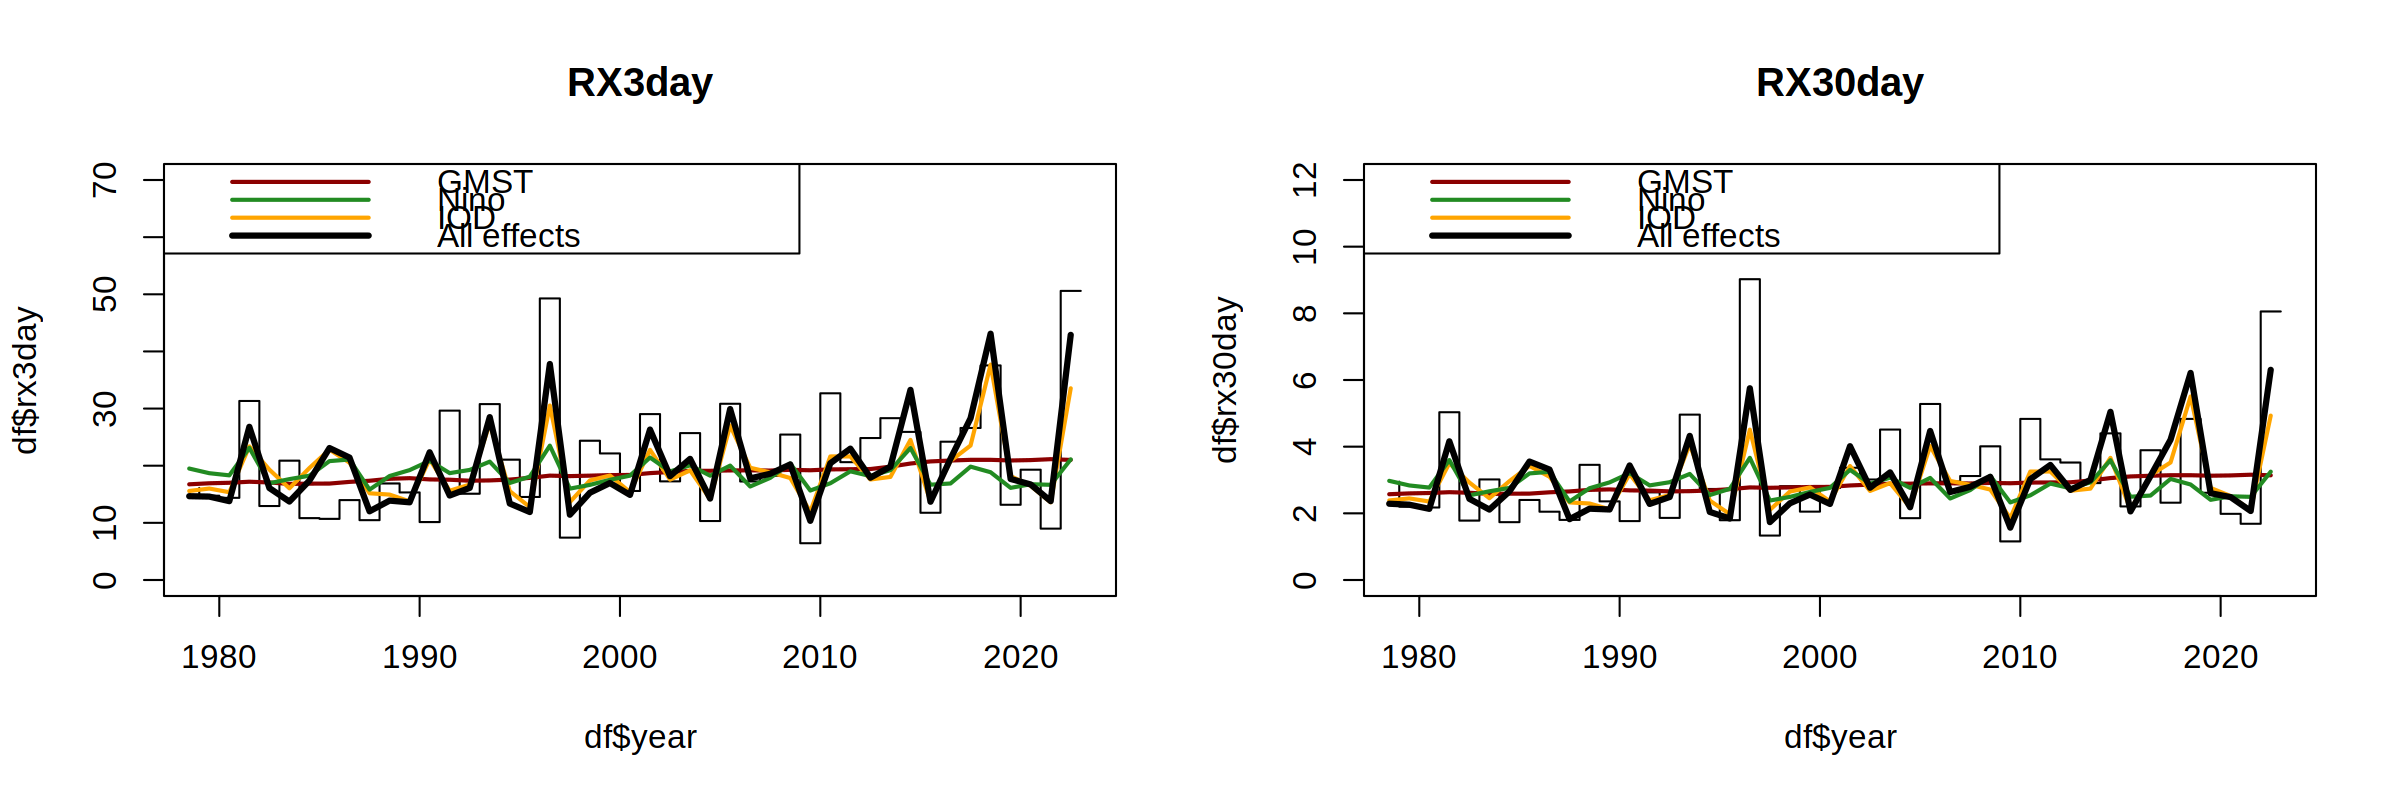

In [13]:
prep_window(c(1,3)); par(mfrow = c(1,2))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plot(df$year, df$rx3day, type = "S", ylim = c(0,70), main = "RX3day")

gmst_pred <- predict(lm_3day, newdata = data.frame(df["gmst"], "iod" = mean(df$iod), nino34 = mean(df$nino34)))
iod_pred <- predict(lm_3day, newdata = data.frame(df["iod"], "gmst" = mean(df$gmst), nino34 = mean(df$nino34)))
nino_pred <- predict(lm_3day, newdata = data.frame(df["nino34"], "gmst" = mean(df$gmst), iod = mean(df$iod)))

lines(df$year-0.5, exp(gmst_pred), col = "darkred", lwd = 2)
lines(df$year-0.5, exp(iod_pred), col = "orange", lwd = 2)
lines(df$year-0.5, exp(nino_pred), col = "forestgreen", lwd = 2)
lines(df$year-0.5, exp(fitted(lm_3day)), col = "black", lwd = 3)

legend("topleft", legend = c("GMST", "Nino", "IOD", "All effects"), col = c("darkred", "forestgreen", "orange", "black"), lty = 1, lwd = c(2,2,2,3))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plot(df$year, df$rx30day, type = "S", ylim = c(0,12), main = "RX30day")

gmst_pred <- predict(lm_30day, newdata = data.frame(df["gmst"], "iod" = mean(df$iod), nino34 = mean(df$nino34)))
iod_pred <- predict(lm_30day, newdata = data.frame(df["iod"], "gmst" = mean(df$gmst), nino34 = mean(df$nino34)))
nino_pred <- predict(lm_30day, newdata = data.frame(df["nino34"], "gmst" = mean(df$gmst), iod = mean(df$iod)))

lines(df$year-0.5, exp(gmst_pred), col = "darkred", lwd = 2)
lines(df$year-0.5, exp(iod_pred), col = "orange", lwd = 2)
lines(df$year-0.5, exp(nino_pred), col = "forestgreen", lwd = 2)
lines(df$year-0.5, exp(fitted(lm_30day)), col = "black", lwd = 3)

legend("topleft", legend = c("GMST", "Nino", "IOD", "All effects"), col = c("darkred", "forestgreen", "orange", "black"), lty = 1, lwd = c(2,2,2,3))

---
# **Nonstationary GEV**

In [304]:
cov_lag <- "SON"

ts <- merge(load_ts("ts/HoA-flooding_mswep_OND_rx3day.dat", col.names = c("year", "rx3day")),
            load_ts("ts/HoA-flooding_mswep_OND_30day_mean.dat", col.names = c("year", "rx30day")))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

gmst <- load_ts("ts/gmst.dat", col.names = c("year", "gmst"))
iod <- load_ts(paste0("ts/iod_", toupper(cov_lag), ".dat"), col.names = c("year", "iod"))
nino <- load_ts(paste0("ts/nino3.4-detrended_", toupper(cov_lag), ".dat"), col.names = c("year", "nino34"))

df <- merge(merge(merge(gmst, iod), nino), ts)

df$log_rx3day <- log(df$rx3day)
df$log_rx30day <- log(df$rx30day)

## **Shift or fixed-dispersion**

In [11]:
mdl_fd <- fit_ns("gev", "fixeddisp", df, "rx3day", c("gmst", "iod"))
mdl_shift <- fit_ns("gev", "shift", df, "rx3day", c("gmst", "iod"))

cov <- df[df$year == 2023, c("gmst", "iod")]
yl <- c(0,120)

rx3day_2023 <- df$rx3day[df$year == 2023]
iod_2023 <- df$iod[df$year == 2023]
gmst_2023 <- df$gmst[df$year == 2023]

In [13]:
mdl_fd$value
mdl_shift$value

[1] 145.9724

[1] 147.5502

In [252]:
prep_window(c(1,3)); par(mfrow = c(1,2))

png("fig/timeseries-gmst-iod.png", height = 480, width = 480 * 3); par(mfrow = c(1,2), cex = 1.4); {
    plot(df$year, df$gmst, type = "S", lwd = 2, xlab = "", main = "GMST")
    plot(df$year, df$iod, type = "S", lwd = 2, xlab = "", main = "IOD", ylim = c(-2,2))
    abline(h = 0, col = "darkred")
    abline(h = mean(df$iod), col = "darkred", lty = 2)
}; dev.off()

png 
  2

In [256]:
prep_window(c(1,3)); par(mfrow = c(1,2))

iod_clim <- mean(df$iod[(df$year >= 1990) & (df$year <= 2020)])

png("fig/ns-gev_mswep_returnlevels.png", height = 480, width = 480 * 3); par(mfrow = c(1,2), cex = 1.4); {
    plot_returnlevels(mdl_fd, cov = data.frame("gmst" = gmst_2023, "iod" = iod_clim), cov_cf = data.frame("gmst" = gmst_2023 - 1.2, "iod" = iod_clim),
                      main = "Fixed-dispersion model", ylim = yl, legend_pos = "topleft")
    points(1/seq(1,0,length.out = nrow(df)+2)[2:(nrow(df)+1)], sort(df$rx3day), pch = 20, col = adjustcolor("black", 0.5))
    plot_returnlevels(mdl_shift, cov = data.frame("gmst" = gmst_2023, "iod" = iod_clim), cov_cf = data.frame("gmst" = gmst_2023 - 1.2, "iod" = iod_clim),
                      main = "Shift-fit model", ylim = yl, legend_pos = "topleft")
    points(1/seq(1,0,length.out = nrow(df)+2)[2:(nrow(df)+1)], sort(df$rx3day), pch = 20, col = adjustcolor("black", 0.5))
}; dev.off()

png 
  2

In [257]:
prep_window(c(1,3)); par(mfrow = c(1,2))

png("fig/ns-gev_mswep_trend-vs-time.png", height = 480, width = 480 * 3); par(mfrow = c(1,2), cex = 1.4); {
    plot_trend(mdl_fd, main = "Fixed dispersion", ylim = yl)
    plot_trend(mdl_shift, main = "Shift", ylim = yl)
}; dev.off()

png 
  2

In [258]:
prep_window(c(1,3)); par(mfrow = c(1,2))

fix_gmst <- cbind(df[,c("iod")], mean(df$gmst[(df$year >= 1990) & (df$year <= 2020)]))

png("fig/ns-gev_mswep_trend-vs-iod.png", height = 480, width = 480 * 3); par(mfrow = c(1,2), cex = 1.4); {
    plot_covtrend(mdl_fd, xcov = "iod", cov = cov, cov_cf = cov * -1, ylim = yl, nsamp = 10, fixed_cov = fix_gmst, main = "Fixed dispersion")
    plot_covtrend(mdl_shift, xcov = "iod", cov = cov, cov_cf = cov * -1, ylim = yl, nsamp = 10, fixed_cov = fix_gmst, main = "Shift")
}; dev.off()

png 
  2

In [259]:
prep_window(c(1,3)); par(mfrow = c(1,2))

fix_iod <- cbind(df[,c("gmst")], mean(df$iod[(df$year >= 1990) & (df$year <= 2020)]))

png("fig/ns-gev_mswep_trend-vs-gmst.png", height = 480, width = 480 * 3); par(mfrow = c(1,2), cex = 1.4); {
    plot_covtrend(mdl_fd, xcov = "gmst", cov = cov, cov_cf = cov - c(1.2, 0), ylim = yl, nsamp = 10, fixed_cov = fix_iod, main = "Fixed dispersion")
    plot_covtrend(mdl_shift, xcov = "gmst", cov = cov, cov_cf = cov - c(1.2, 0), ylim = yl, nsamp = 10, fixed_cov = fix_iod, main = "Shift")
}; dev.off()

png 
  2

### **Tables of model fitting results**

In [190]:
round(rbind("scale fit" = c(mdl_fd$par, "RP_2023" = return_period(mdl_fd, rx3day_2023, fixed_cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023))),
            "shift fit" = c(mdl_shift$par, "RP_2023" = return_period(mdl_shift, rx3day_2023, fixed_cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023)))), 3)

,mu0,sigma0,alpha_gmst,alpha_iod,shape,RP_2023
scale fit,18.987,6.321,10.288,7.947,-0.119,4.559
shift fit,20.333,5.884,10.905,9.974,-0.125,24.301


In [17]:
# return periods
rp_fd <- return_period(mdl_fd, rx3day_2023, fixed_cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023))
rp_shift <- return_period(mdl_shift, rx3day_2023, fixed_cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023))

round(rbind("scale" = c("GMST 2023, IOD 2023" = return_period(mdl_fd, rx3day_2023, fixed_cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023)),
                          "GMST 2023, IOD neutral" = return_period(mdl_fd, rx3day_2023, fixed_cov = data.frame("gmst" = gmst_2023, "iod" = 0)),
                          "GMST -1.2, IOD 2023" = return_period(mdl_fd, rx3day_2023, fixed_cov = data.frame("gmst" = -1.2, "iod" = iod_2023)),
                          "GMST -1.2, IOD neutral" = return_period(mdl_fd, rx3day_2023, fixed_cov = data.frame("gmst" = -1.2, "iod" = 0))),
     "shift" = c("GMST 2023, IOD 2023" = return_period(mdl_shift, rx3day_2023, fixed_cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023)),
                         "GMST 2023, IOD neutral" = return_period(mdl_shift, rx3day_2023, fixed_cov = data.frame("gmst" = gmst_2023, "iod" = 0)),
                         "GMST -1.2, IOD 2023" = return_period(mdl_shift, rx3day_2023, fixed_cov = data.frame("gmst" = -1.2, "iod" = iod_2023)),
                         "GMST -1.2, IOD neutral" = return_period(mdl_shift, rx3day_2023, fixed_cov = data.frame("gmst" = -1.2, "iod" = 0)))), 0)

,"GMST 2023, IOD 2023","GMST 2023, IOD neutral","GMST -1.2, IOD 2023","GMST -1.2, IOD neutral"
scale,5,1975,3425,Inf
shift,24,3772,1691,638431919


In [275]:
# PR & change in intensity due to climate change, given the 2023 IOD conditions
round(cbind(sapply(list("scale_fit" = mdl_fd, "shift_fit" = mdl_shift), function(mdl) {
    c("GMST effect | IOD 2023" = prob_ratio(mdl, rx3day_2023, 
                                             cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), 
                                             cov_cf = data.frame("gmst" = -1.2, "iod" = iod_2023)),
       "GMST effect | IOD neutral" = prob_ratio(mdl, rx3day_2023,
                                                cov = data.frame("gmst" = gmst_2023, "iod" = 0), 
                                                cov_cf = data.frame("gmst" = -1.2, "iod" = 0)),
       "IOD effect | GMST 2023" = prob_ratio(mdl, rx3day_2023,
                                             cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), 
                                             cov_cf = data.frame("gmst" = gmst_2023, "iod" = 0)),
      "Combined effect" = prob_ratio(mdl, rx3day_2023,
                                             cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), 
                                             cov_cf = data.frame("gmst" = -1.2, "iod" = 0)))
    }), 
      sapply(list("scale_fit" = mdl_fd, "shift_fit" = mdl_shift), function(mdl) {
    c("GMST effect | IOD 2023" = int_change(mdl, 
                                             cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), 
                                             cov_cf = data.frame("gmst" = -1.2, "iod" = iod_2023)),
       "GMST effect | IOD neutral" = int_change(mdl,
                                                cov = data.frame("gmst" = gmst_2023, "iod" = 0), 
                                                cov_cf = data.frame("gmst" = -1.2, "iod" = 0)),
       "IOD effect | GMST 2023" = int_change(mdl, 
                                             cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), 
                                             cov_cf = data.frame("gmst" = gmst_2023, "iod" = 0)),
      "Combined effect" = int_change(mdl,
                                     cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), 
                                     cov_cf = data.frame("gmst" = -1.2, "iod" = 0)))
          }),
      sapply(list("scale_fit" = mdl_fd, "shift_fit" = mdl_shift), function(mdl) {
    c("GMST effect | IOD 2023" = int_change(mdl, relative = T, rp = 24,
                                             cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), 
                                             cov_cf = data.frame("gmst" = -1.2, "iod" = iod_2023)),
       "GMST effect | IOD neutral" = int_change(mdl, relative = T, rp = 24,
                                                cov = data.frame("gmst" = gmst_2023, "iod" = 0), 
                                                cov_cf = data.frame("gmst" = -1.2, "iod" = 0)),
       "IOD effect | GMST 2023" = int_change(mdl, relative = T, rp = 24,
                                             cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), 
                                             cov_cf = data.frame("gmst" = gmst_2023, "iod" = 0)),
      "Combined effect" = int_change(mdl, relative = T, rp = 24,
                                     cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), 
                                     cov_cf = data.frame("gmst" = -1.2, "iod" = 0)))
    })), 3)

,scale_fit,shift_fit,scale_fit,shift_fit,scale_fit,shift_fit
GMST effect | IOD 2023,753.536,69.737,28.067,13.086,91.593,34.937
GMST effect | IOD neutral,Inf,176940.768,15.043,13.086,91.593,57.919
IOD effect | GMST 2023,435.492,155.841,27.244,14.863,86.577,41.656
Combined effect,Inf,27574713.290,42.287,27.949,257.469,123.701


In [297]:
rl_hist <- map_from_u(map_to_u(mdl_fd, rx3day_2023, fixed_cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023)), mdl_fd, fixed_cov = data.frame("gmst" = gmst_2023 - 1.2, "iod" = iod_2023))
rl_neut <- map_from_u(map_to_u(mdl_fd, rx3day_2023, fixed_cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023)), mdl_fd, fixed_cov = data.frame("gmst" = gmst_2023, "iod" = 0))
rl_histneut <- map_from_u(map_to_u(mdl_fd, rx3day_2023, fixed_cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023)), mdl_fd, fixed_cov = data.frame("gmst" = gmst_2023 - 1.2, "iod" = 0))

In [299]:
rl_hist
rl_neut
rl_histneut

[1] 26.40695

[1] 27.11689

[1] 14.15336

In [309]:
# check shift fit against fevd - results should be identical
mdl_fevd <- fevd(rx3day, df, location.fun = ~ gmst + iod)

In [310]:
rbind("FEVD" = strip(mdl_fevd),
      "shift" = mdl_shift$par[c("mu0", "alpha_gmst", "alpha_iod", "sigma0", "shape")],
      "scale" = mdl_fd$par[c("mu0", "alpha_gmst", "alpha_iod", "sigma0", "shape")])

,mu0,mu1,mu2,scale,shape
FEVD,18.59747,6.332572,12.027307,6.091016,-0.2061499
shift,20.33424,10.906338,9.973765,5.883645,-0.1249577
scale,18.98658,10.292310,7.948275,6.321611,-0.1188144


## **Compare fit to single-covariate models**

In [340]:
source("../../wwa/wwa_model-fitting.R")

In [15]:
iod_fd <- fit_ns("gev", "fixeddisp", df, "rx3day", "iod")
gmst_fd <- fit_ns("gev", "fixeddisp", df, "rx3day", "gmst")

iod_shift <- fit_ns("gev", "shift", df, "rx3day", "iod")
gmst_shift <- fit_ns("gev", "shift", df, "rx3day", "gmst")

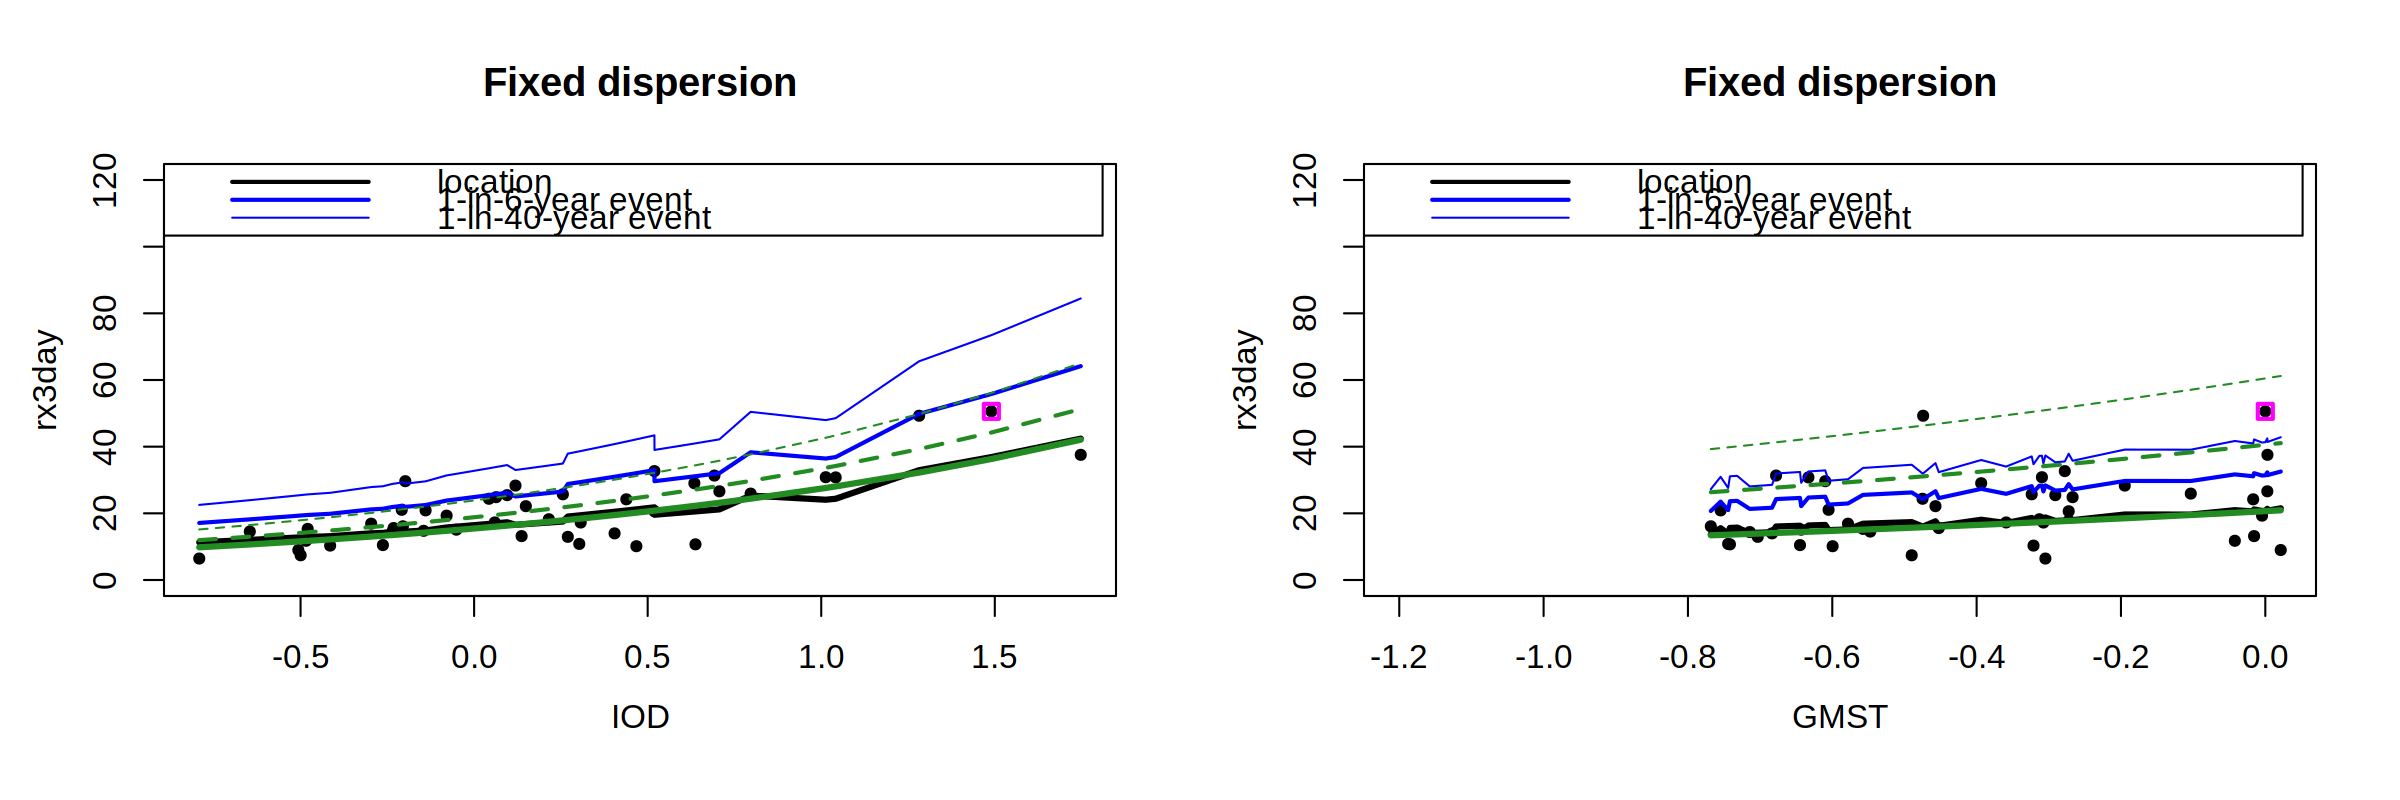

In [56]:
# if we fit to only one factor, the variability is wrong: too low if we exclude GMST and too high if we exclude IOD
prep_window(c(1,3)); par(mfrow = c(1,2))

fix_gmst <- cbind(df[,c("iod")], mean(df$gmst[(df$year >= 1990) & (df$year <= 2020)]))
fix_iod <- cbind(df[,c("gmst")], mean(df$iod[(df$year >= 1990) & (df$year <= 2020)]))

plot_covtrend(mdl_fd, xcov = "iod", cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), cov_cf = data.frame("gmst" = gmst_2023, "iod" = 0), ylim = yl, nsamp = 1, 
              fixed_cov = fix_gmst, main = "Fixed dispersion")

x <- df$iod; o <- order(x)
lines(x[o], ns_pars(iod_fd)$loc[o], col = "forestgreen", lwd = 3, lty = 1)
lines(x[o], eff_return_level(6, iod_fd, fixed_cov = fix_gmst)[o], col = "forestgreen", lwd = 2, lty = 2)
lines(x[o], eff_return_level(40, iod_fd, fixed_cov = fix_gmst)[o], col = "forestgreen", lwd = 1, lty = 2)

plot_covtrend(mdl_fd, xcov = "gmst", cov = data.frame("gmst" = gmst_2023, "iod" = 0), cov_cf = data.frame("gmst" = gmst_2023 - 1.2, "iod" = 0), ylim = yl, nsamp = 1, 
              fixed_cov = fix_iod, main = "Fixed dispersion")
x <- df$gmst; o <- order(x)
lines(x[o], ns_pars(gmst_fd)$loc[o], col = "forestgreen", lwd = 3, lty = 1)
lines(x[o], eff_return_level(6, gmst_fd, fixed_cov = fix_iod)[o], col = "forestgreen", lwd = 2, lty = 2)
lines(x[o], eff_return_level(40, gmst_fd, fixed_cov = fix_iod)[o], col = "forestgreen", lwd = 1, lty = 2)

In [70]:
# estimate return period without accounting for IOD variability
return_period(gmst_fd, x = df$rx3day[df$year == 2023], fixed_cov = data.frame("gmst" = gmst_2023))

[1] 28.53338

In [73]:
# return period conditioned on IOD state over last ~40 years
1/(mean(sapply(df$iod[df$year >= 1980], function(i) {
    1/return_period(mdl_fd, x = df$rx3day[df$year == 2023], fixed_cov = data.frame("gmst" = gmst_2023, "iod" = i))
})))

[1] 41.94183

In [79]:
# return period conditioned on IOD state over last 170 years
1/(mean(sapply(iod$iod[iod$year >= 1923], function(i) {
    1/return_period(mdl_fd, x = df$rx3day[df$year == 2023], fixed_cov = data.frame("gmst" = gmst_2023, "iod" = i))
})))

[1] 68.22209

In [78]:
# return period conditioned on IOD state over last 170 years
1/(mean(sapply(iod$iod, function(i) {
    1/return_period(mdl_fd, x = df$rx3day[df$year == 2023], fixed_cov = data.frame("gmst" = gmst_2023, "iod" = i))
})))

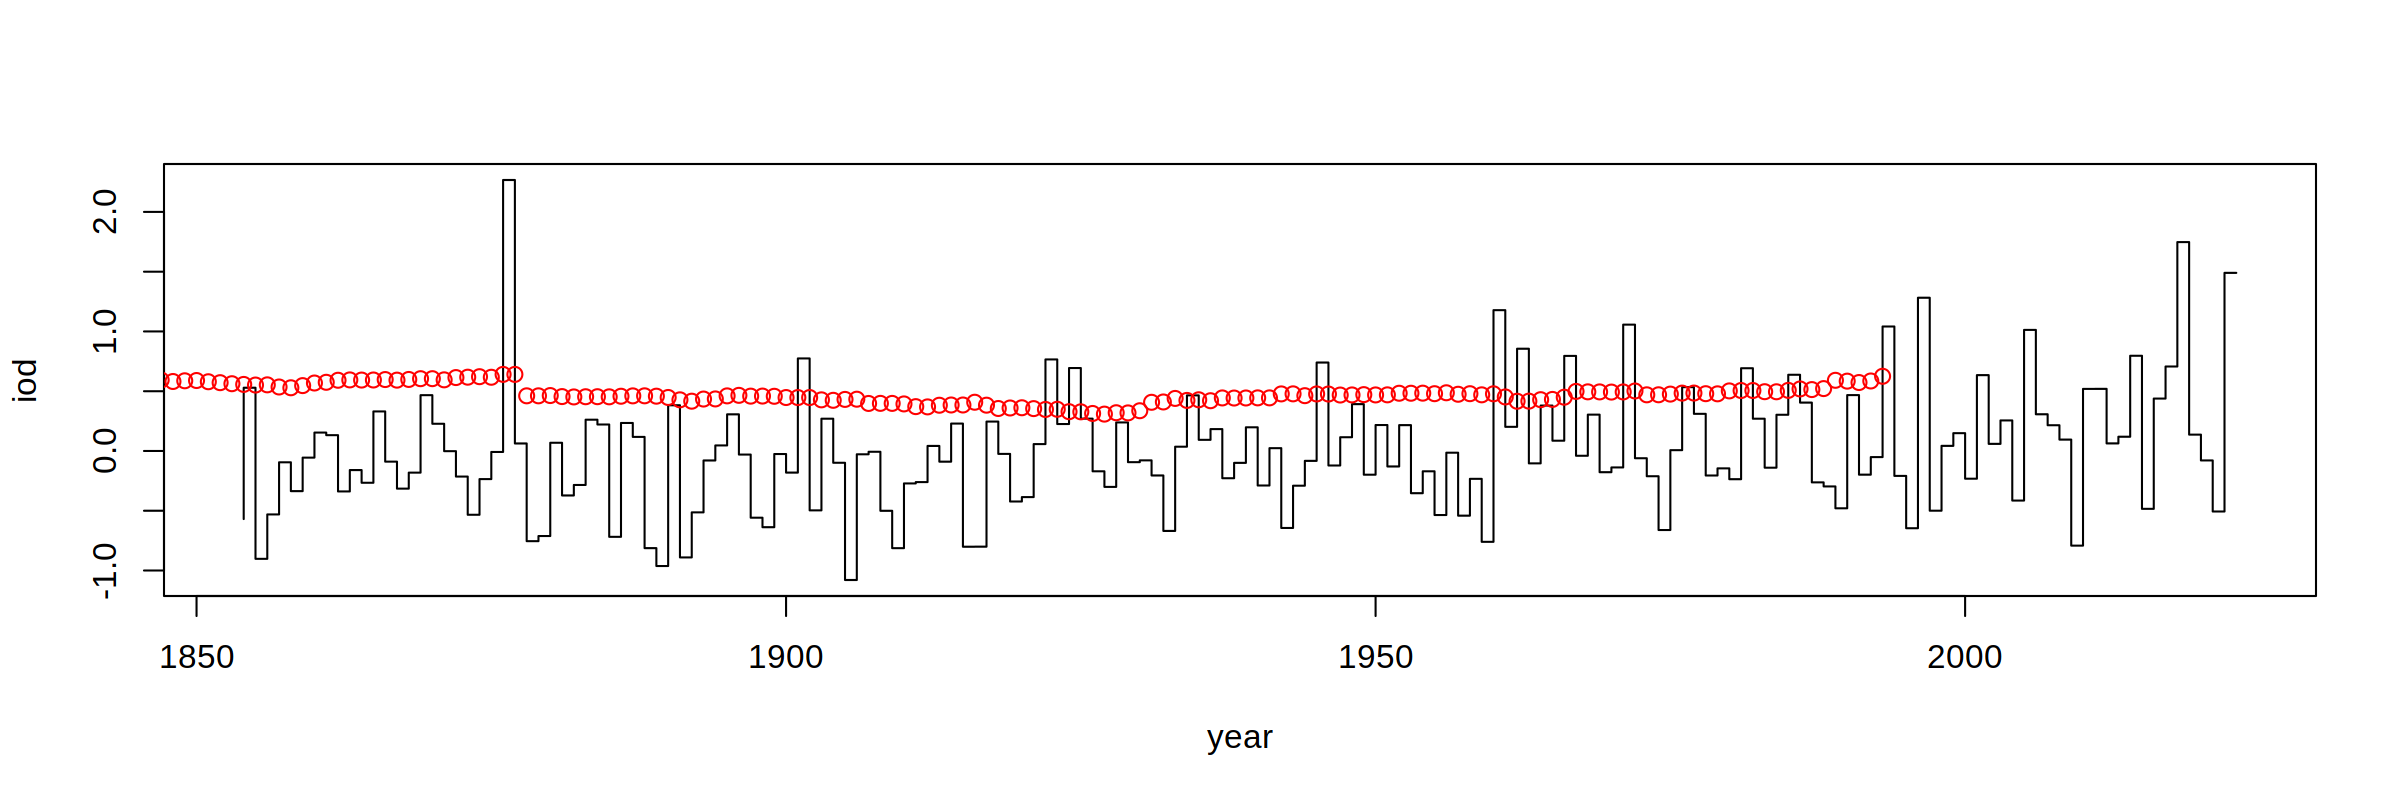

In [92]:
plot(iod, type = "S")

points(seq(1810, 1993), sapply(seq(1810, 1993), function(y) {
    sd(iod$iod[(iod$year >= y) & (iod$year <= y+30)])
}), ylim = c(0,1), col = "red")

In [18]:
# compare parameters
plyr::rbind.fill("both" = data.frame(t(c(mdl_fd$par, "rp2023" = rp_fd))),
                 "gmst" = data.frame(t(c(setNames(gmst_fd$par, c("mu0", "sigma0", "alpha_gmst", "shape")), "rp2023" = return_period(gmst_fd, rx3day_2023, fixed_cov = gmst_2023)))),
                 "iod" = data.frame(t(c(setNames(iod_fd$par, c("mu0", "sigma0", "alpha_iod", "shape")), "rp2023" = return_period(iod_fd, rx3day_2023, fixed_cov = iod_2023)))))
cat("\n")
plyr::rbind.fill("both" = data.frame(t(c(mdl_shift$par, "rp2023" = rp_shift))),
                 "gmst" = data.frame(t(c(setNames(gmst_shift$par, c("mu0", "sigma0", "alpha_gmst", "shape")), "rp2023" = return_period(gmst_shift, rx3day_2023, fixed_cov = gmst_2023)))),
                 "iod" = data.frame(t(c(setNames(iod_shift$par, c("mu0", "sigma0", "alpha_iod", "shape")), "rp2023" = return_period(iod_shift, rx3day_2023, fixed_cov = iod_2023)))))

ERROR: Error in rowSums(pars[grepl("alpha", names(pars)), drop = F] * fixed_cov): 'x' must be an array of at least two dimensions


## **TAMSAT**

In [235]:
cov_lag <- "SON"

ts <- merge(load_ts("ts/HoA-flooding_TAMSAT_OND_Rx3day.dat", col.names = c("year", "rx3day")),
            load_ts("ts/HoA-flooding_TAMSAT_OND_30day_mean.dat", col.names = c("year", "rx30day")))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

gmst <- load_ts("ts/gmst.dat", col.names = c("year", "gmst"))
iod <- load_ts(paste0("ts/iod_", toupper(cov_lag), ".dat"), col.names = c("year", "iod"))
nino <- load_ts(paste0("ts/nino3.4-detrended_", toupper(cov_lag), ".dat"), col.names = c("year", "nino34"))

df <- merge(merge(merge(gmst, iod), nino), ts)

df$log_rx3day <- log(df$rx3day)
df$log_rx30day <- log(df$rx30day)

In [236]:
mdl_fd <- fit_ns("gev", "fixeddisp", df, "rx3day", c("gmst", "iod"))
mdl_shift <- fit_ns("gev", "shift", df, "rx3day", c("gmst", "iod"))

cov <- df[df$year == 2023, c("gmst", "iod")]
yl <- c(0,120)

rx3day_2023 <- df$rx3day[df$year == 2023]
iod_2023 <- df$iod[df$year == 2023]
gmst_2023 <- df$gmst[df$year == 2023]

In [237]:
prep_window(c(1,3)); par(mfrow = c(1,2))

iod_clim <- mean(df$iod[(df$year >= 1990) & (df$year <= 2020)])

png("fig/ns-gev_tamsat_returnlevels.png", height = 480, width = 480 * 3); par(mfrow = c(1,2), cex = 1.4); {
    plot_returnlevels(mdl_fd, cov = cov, cov_cf = cov - c(1.2, iod_clim), main = "Fixed-dispersion model", ylim = yl, legend_pos = "topleft")
    points(1/seq(1,0,length.out = nrow(df)+2)[2:(nrow(df)+1)], sort(df$rx3day), pch = 20, col = adjustcolor("black", 0.5))
    plot_returnlevels(mdl_shift, cov = cov, cov_cf = cov - c(1.2, iod_clim), main = "Shift-fit model", ylim = yl, legend_pos = "topleft")
    points(1/seq(1,0,length.out = nrow(df)+2)[2:(nrow(df)+1)], sort(df$rx3day),, pch = 20, col = adjustcolor("black", 0.5))
}; dev.off()

png 
  2

In [238]:
prep_window(c(1,3)); par(mfrow = c(1,2))

png("fig/ns-gev_tamsat_trend-vs-time.png", height = 480, width = 480 * 3); par(mfrow = c(1,2), cex = 1.4); {
    plot_trend(mdl_fd, main = "Fixed dispersion", ylim = yl)
    plot_trend(mdl_shift, main = "Shift", ylim = yl)
}; dev.off()

png 
  2

In [239]:
prep_window(c(1,3)); par(mfrow = c(1,2))

fix_gmst <- cbind(df[,c("iod")], mean(df$gmst[(df$year >= 1990) & (df$year <= 2020)]))

png("fig/ns-gev_tamsat_trend-vs-iod.png", height = 480, width = 480 * 3); par(mfrow = c(1,2), cex = 1.4); {
    plot_covtrend(mdl_fd, xcov = "iod", cov = cov, cov_cf = cov * -1, ylim = yl, nsamp = 10, fixed_cov = fix_gmst, main = "Fixed dispersion")
    plot_covtrend(mdl_shift, xcov = "iod", cov = cov, cov_cf = cov * -1, ylim = yl, nsamp = 10, fixed_cov = fix_gmst, main = "Shift")
}; dev.off()

png 
  2

In [240]:
prep_window(c(1,3)); par(mfrow = c(1,2))

fix_iod <- cbind(df[,c("gmst")], mean(df$iod[(df$year >= 1990) & (df$year <= 2020)]))

png("fig/ns-gev_tamsat_trend-vs-gmst.png", height = 480, width = 480 * 3); par(mfrow = c(1,2), cex = 1.4); {
    plot_covtrend(mdl_fd, xcov = "gmst", cov = cov, cov_cf = cov - c(1.2, 0), ylim = yl, nsamp = 10, fixed_cov = fix_iod, main = "Fixed dispersion")
    plot_covtrend(mdl_shift, xcov = "gmst", cov = cov, cov_cf = cov - c(1.2, 0), ylim = yl, nsamp = 10, fixed_cov = fix_iod, main = "Shift")
}; dev.off()

png 
  2

### **Tables of model fitting results**

In [241]:
round(rbind("scale fit" = c(mdl_fd$par, "RP_2023" = return_period(mdl_fd, rx3day_2023, fixed_cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023))),
            "shift fit" = c(mdl_shift$par, "RP_2023" = return_period(mdl_shift, rx3day_2023, fixed_cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023)))), 3)

,mu0,sigma0,alpha_gmst,alpha_iod,shape,RP_2023
scale fit,21.000,8.933,11.333,9.446,0.005,1.833
shift fit,22.902,7.768,12.513,13.347,-0.016,1.925


In [242]:
t(round(c("GMST 2023, IOD 2023" = return_period(mdl_shift, rx3day_2023, fixed_cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023)),
          "GMST 2023, IOD neutral" = return_period(mdl_shift, rx3day_2023, fixed_cov = data.frame("gmst" = gmst_2023, "iod" = 0)),
          "GMST -1.2, IOD 2023" = return_period(mdl_shift, rx3day_2023, fixed_cov = data.frame("gmst" = -1.2, "iod" = iod_2023)),
          "GMST -1.2, IOD neutral" = return_period(mdl_shift, rx3day_2023, fixed_cov = data.frame("gmst" = -1.2, "iod" = 0))), 3))

"GMST 2023, IOD 2023","GMST 2023, IOD neutral","GMST -1.2, IOD 2023","GMST -1.2, IOD neutral"
1.925,19.384,10.326,148.385


In [243]:
return_period(mdl_shift, rx3day_2023, fixed_cov = data.frame("gmst" = -1.2, "iod" = 0))

[1] 148.385

In [244]:
return_period(mdl_shift, rx3day_2023, fixed_cov = data.frame("gmst" = -1.2, "iod" = iod_2023))

In [245]:
# PR due to climate change, given the 2023 IOD conditions
round(cbind(sapply(list("scale_fit" = mdl_fd, "shift_fit" = mdl_shift), function(mdl) {
    c("GMST effect | IOD 2023" = prob_ratio(mdl, rx3day_2023, 
                                             cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), 
                                             cov_cf = data.frame("gmst" = -1.2, "iod" = iod_2023)),
       "GMST effect | IOD neutral" = prob_ratio(mdl, rx3day_2023,
                                                cov = data.frame("gmst" = gmst_2023, "iod" = 0), 
                                                cov_cf = data.frame("gmst" = -1.2, "iod" = 0)),
       "IOD effect | GMST 2023" = prob_ratio(mdl, rx3day_2023,
                                             cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), 
                                             cov_cf = data.frame("gmst" = gmst_2023, "iod" = 0)),
      "Combined effect" = prob_ratio(mdl, rx3day_2023,
                                             cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), 
                                             cov_cf = data.frame("gmst" = -1.2, "iod" = 0)))
    }), 
      sapply(list("scale_fit" = mdl_fd, "shift_fit" = mdl_shift), function(mdl) {
    c("GMST effect | IOD 2023" = int_change(mdl, 
                                             cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), 
                                             cov_cf = data.frame("gmst" = -1.2, "iod" = iod_2023)),
       "GMST effect | IOD neutral" = int_change(mdl, 
                                                cov = data.frame("gmst" = gmst_2023, "iod" = 0), 
                                                cov_cf = data.frame("gmst" = -1.2, "iod" = 0)),
       "IOD effect | GMST 2023" = int_change(mdl, 
                                             cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), 
                                             cov_cf = data.frame("gmst" = gmst_2023, "iod" = 0)),
      "Combined effect" = int_change(mdl, 
                                     cov = data.frame("gmst" = gmst_2023, "iod" = iod_2023), 
                                     cov_cf = data.frame("gmst" = -1.2, "iod" = 0)))
    })), 3)

,scale_fit,shift_fit,scale_fit,shift_fit
GMST effect | IOD 2023,7.457,5.363,38.418,15.016
GMST effect | IOD neutral,85.875,7.655,19.653,15.016
IOD effect | GMST 2023,8.307,10.067,39.365,19.889
Combined effect,713.329,77.065,59.018,34.905


---
---
# **Temporary working area**